In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
import pandas as pd
from utils import target_loss 
from loader import build_dataloader
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

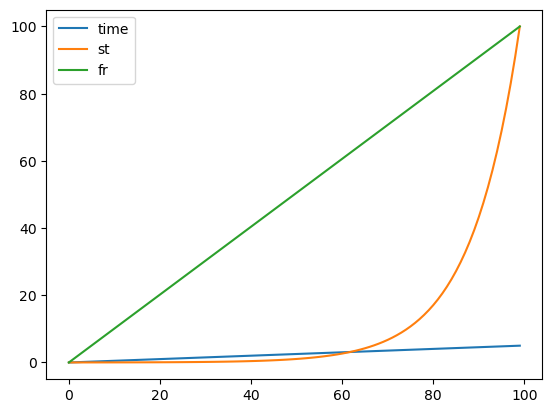

In [2]:
size = 100
t_max = 5
t = np.linspace(0, t_max, size)
min_fr, max_fr = 0.01, 100
fr = np.linspace(min_fr, max_fr, size)
start_st, end_st = 0.01, 100
st = np.logspace(np.log10(start_st), np.log10(end_st), size, endpoint = True)
plt.plot(t, label="time")
plt.plot(st, label="st")
plt.plot(fr, label="fr")
plt.legend()

In [3]:
# the function that we generate the data with
def f(t, st, fr):
    return st**2 * fr * (1 - t/st - np.exp(-t/st))
'''def f(t, st, fr):
    return  st + fr + t'''
data = []
for st_ in st:
    for fr_ in fr:
        example = list(f(t, st_, fr_))
        t_pred = np.random.uniform(0, t_max)
        pred = f(t_pred,st_,fr_)
        example.append(fr_)
        example.append(st_)
        example.append(t_pred)
        example.append(pred)
        data.append(example)
data = np.array(data)
colummns = [str(i) for i in range(size)]
colummns.append("fr")
colummns.append("st")
colummns.append("t_pred")
colummns.append("pred") 
df = pd.DataFrame(data,columns=colummns)
df.shape

(10000, 104)

In [4]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(size,1,3,100)

# Load and prepare training data
dataloader = build_dataloader(batch_size =100, size=size)

In [5]:
# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 200
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
hist_error = []
hist_loss = []
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.009, total_iters=N_EPOCHS)
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, _, question, answer = minibatch['time_series'] / 5, minibatch['fr'] / 5, minibatch['st'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5
        
        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1)
        # build the output
        outputs = answer

        optimizer.zero_grad()
        # print(inputs[0])
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    # break
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
    
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1: SGD lr 0.001000 -> 0.000995
Epoch 1 -- loss 195.685898, RMS error 0.777570 
Epoch 2: SGD lr 0.000995 -> 0.000990
Epoch 2 -- loss 150.055344, RMS error 0.673451 
Epoch 3: SGD lr 0.000990 -> 0.000985
Epoch 3 -- loss 109.493546, RMS error 0.599437 
Epoch 4: SGD lr 0.000985 -> 0.000980
Epoch 4 -- loss 88.250725, RMS error 0.532989 
Epoch 5: SGD lr 0.000980 -> 0.000975
Epoch 5 -- loss 65.051247, RMS error 0.445076 
Epoch 6: SGD lr 0.000975 -> 0.000970
Epoch 6 -- loss 59.166557, RMS error 0.410005 
Epoch 7: SGD lr 0.000970 -> 0.000965
Epoch 7 -- loss 56.628197, RMS error 0.391810 
Epoch 8: SGD lr 0.000965 -> 0.000960
Epoch 8 -- loss 51.541378, RMS error 0.367567 
Epoch 9: SGD lr 0.000960 -> 0.000955
Epoch 9 -- loss 51.247433, RMS error 0.358923 
Epoch 10: SGD lr 0.000955 -> 0.000950
Epoch 10 -- loss 44.713139, RMS error 0.335474 
Epoch 11: SGD lr 0.000950 -> 0.000945
Epoch 11 -- loss 48.592007, RMS error 0.338855 
Epoch 12: SGD lr 0.000945 -> 0.000941
Epoch 12 -- loss 43.889771, RMS

In [6]:


print("Original Data:", data)
print("Window Means:", window_means)


Original Data: [[ 0.00000000e+00 -4.05691115e-06 -9.10105114e-06 ...  1.00000000e-02
   3.50764592e+00 -3.49764592e-04]
 [ 0.00000000e+00 -4.13804937e-04 -9.28307216e-04 ...  1.00000000e-02
   9.10899737e-01 -9.18917732e-03]
 [ 0.00000000e+00 -8.23552963e-04 -1.84751338e-03 ...  1.00000000e-02
   1.04070359e+00 -2.09232829e-02]
 ...
 [ 0.00000000e+00 -1.24940704e-01 -4.99678698e-01 ...  1.00000000e+02
   2.58792809e+00 -3.25292094e+02]
 [ 0.00000000e+00 -1.26228621e-01 -5.04829499e-01 ...  1.00000000e+02
   2.47627427e+00 -3.01010353e+02]
 [ 0.00000000e+00 -1.27516538e-01 -5.09980300e-01 ...  1.00000000e+02
   1.83969526e-02 -1.69213557e-02]]


NameError: name 'window_means' is not defined

In [ ]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error)
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()

: 

: 